# KaiOS Usage Analysis 2023

[T343184](https://phabricator.wikimedia.org/T343184)

The KaiOS app is available in both the KaiStore(≈ outside India) and the JioStore (≈ in India). We want basic stats showing the current rate of app usage and downloads segmented by store.

The (rather hacky) way to distinguish is that apps installed from the JioStore (≈ in India) have a 4 part version number (e.g. 1.0.4.0) while apps installed from the KaiStore (≈ outside India) have a 3 part version number (e.g. 1.0.4).

In [1]:
from wmfdata import hive, spark
import wmfdata 

import matplotlib as mpl
import math
import pandas as pd
import numpy as np

In [ ]:
spark_session = wmfdata.spark.create_session(app_name='pyspark regular; kaios-stats',
                                  type='yarn-large')  

In [6]:
## plot style setting
mpl.style.use({
    "axes.grid": True,
    "axes.autolimit_mode": "data",
    "font.size": 16,
    "xtick.bottom": False,
    "ytick.left": False,
    "lines.linewidth": 3,
    "figure.figsize": (12, 7),
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "figure.dpi": 300
})

## Pageviews

In [53]:
pageviews = spark.run("""
WITH app_pv AS (
    SELECT
      DATE_TRUNC('DAY', TO_TIMESTAMP(dt)) AS dt,
      event.pageview_token,
      IF(
          SIZE(SPLIT(FIRST(event.app_version), '\\\\.')) = 3,
            'KaiStore',
            'JioStore'
        ) AS store
    FROM event.inukapageview 
    WHERE event.client_type = 'kaios-app'
    AND DATE_TRUNC('day', TO_TIMESTAMP(dt)) < CURRENT_DATE
    GROUP BY DATE_TRUNC('DAY', TO_TIMESTAMP(dt)),event.pageview_token
)

SELECT 
    dt, 
    store,
    COUNT(DISTINCT pageview_token) AS pvs
FROM app_pv
GROUP BY dt,store

""")

Text(0, 0.5, 'daily pageviews')

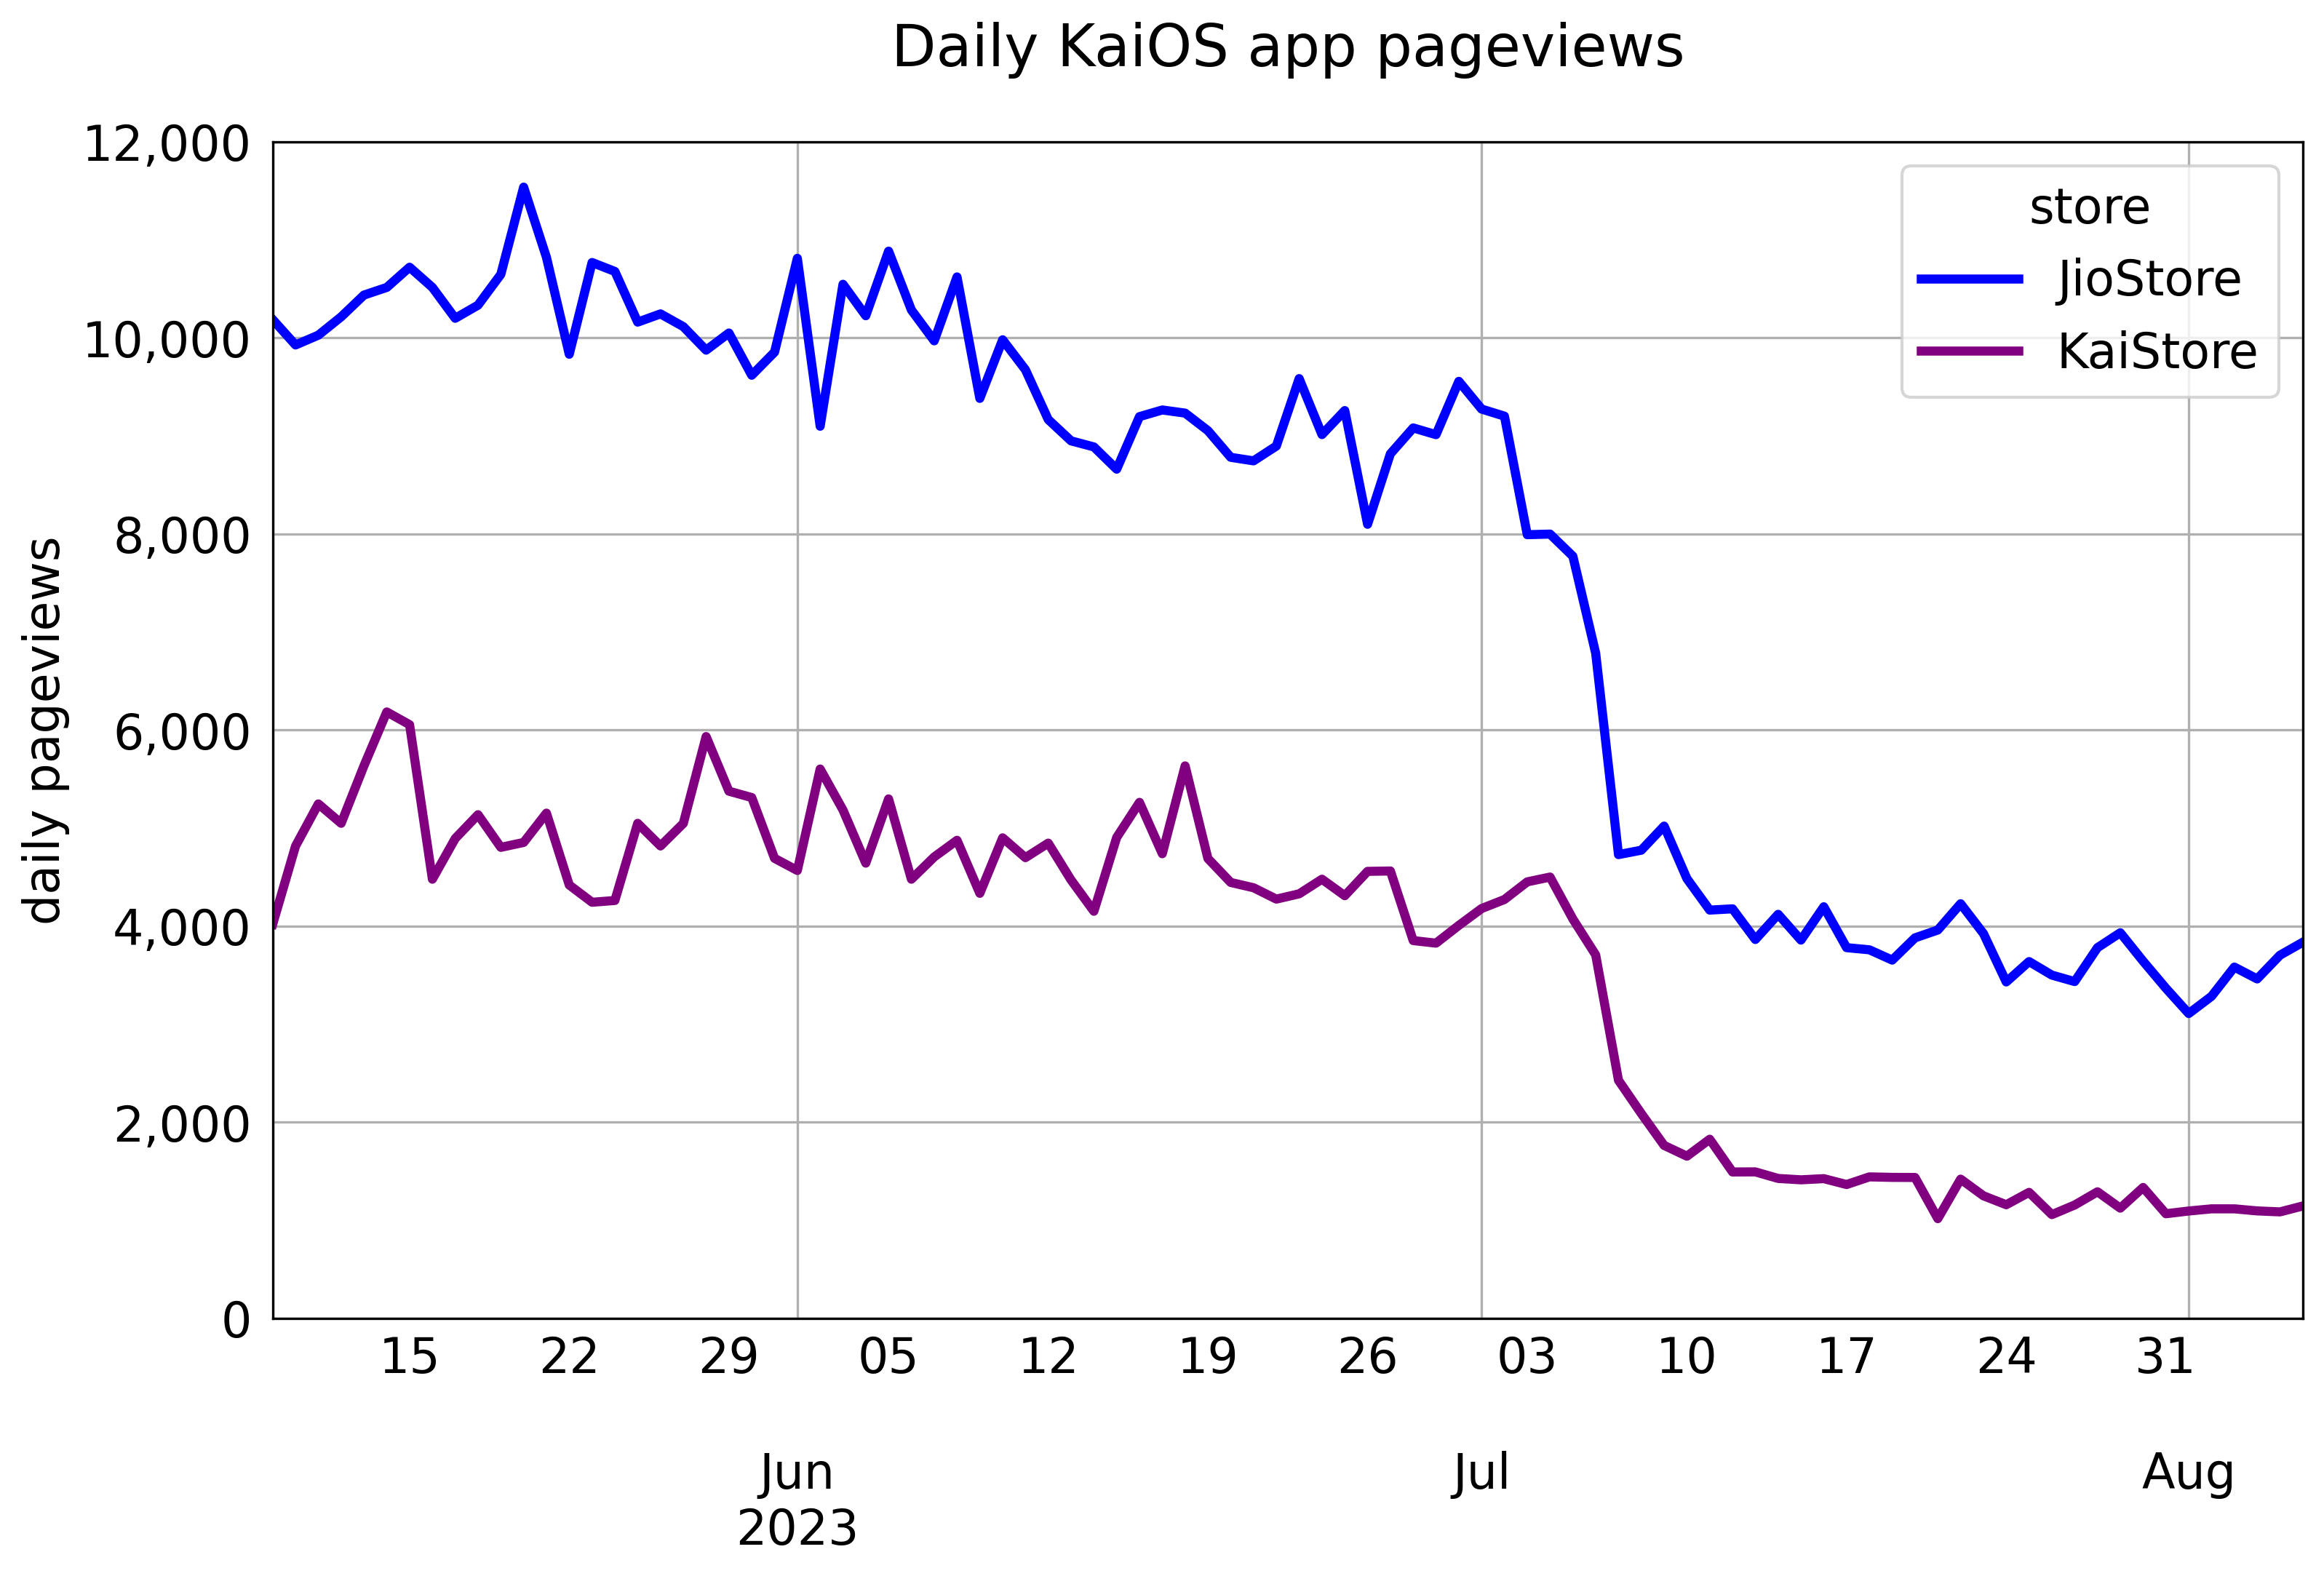

In [56]:
ax = (
    pageviews
    .groupby(["dt", "store"])
    ["pvs"].sum()
    .unstack()
    .plot(color = ("blue", "purple"))
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 12000))

ax.set_title("Daily KaiOS app pageviews", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily pageviews")


## Active Users

In [46]:
user = spark.run("""
    WITH app_user AS (
        SELECT
            DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)) AS dt,
            ipv.event.user_id AS user_id,
            IF(
                SIZE(SPLIT(FIRST(ipv.event.app_version), '\\\\.')) = 3,
                'KaiStore',
                'JioStore'
            ) AS store,
            IF(
                DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)) = DATE_TRUNC('DAY', TO_TIMESTAMP(FIRST(kafr.dt))),
                'first-time',
                'returning'
            ) AS user_type
        FROM event.inukapageview ipv
        LEFT JOIN event_sanitized.kaiosappfirstrun kafr ON ipv.event.user_id = kafr.event.app_id
        WHERE
            ipv.event.client_type = 'kaios-app'
            AND DATE_TRUNC('day', TO_TIMESTAMP(ipv.dt)) < CURRENT_DATE
        GROUP BY
          DATE_TRUNC('DAY', TO_TIMESTAMP(ipv.dt)), ipv.event.user_id
    )
    SELECT
        dt,
        store,
        user_type,
        COUNT(*) AS users
    FROM app_user
    GROUP BY dt, store,user_type
""")

Text(0, 0.5, 'daily users')

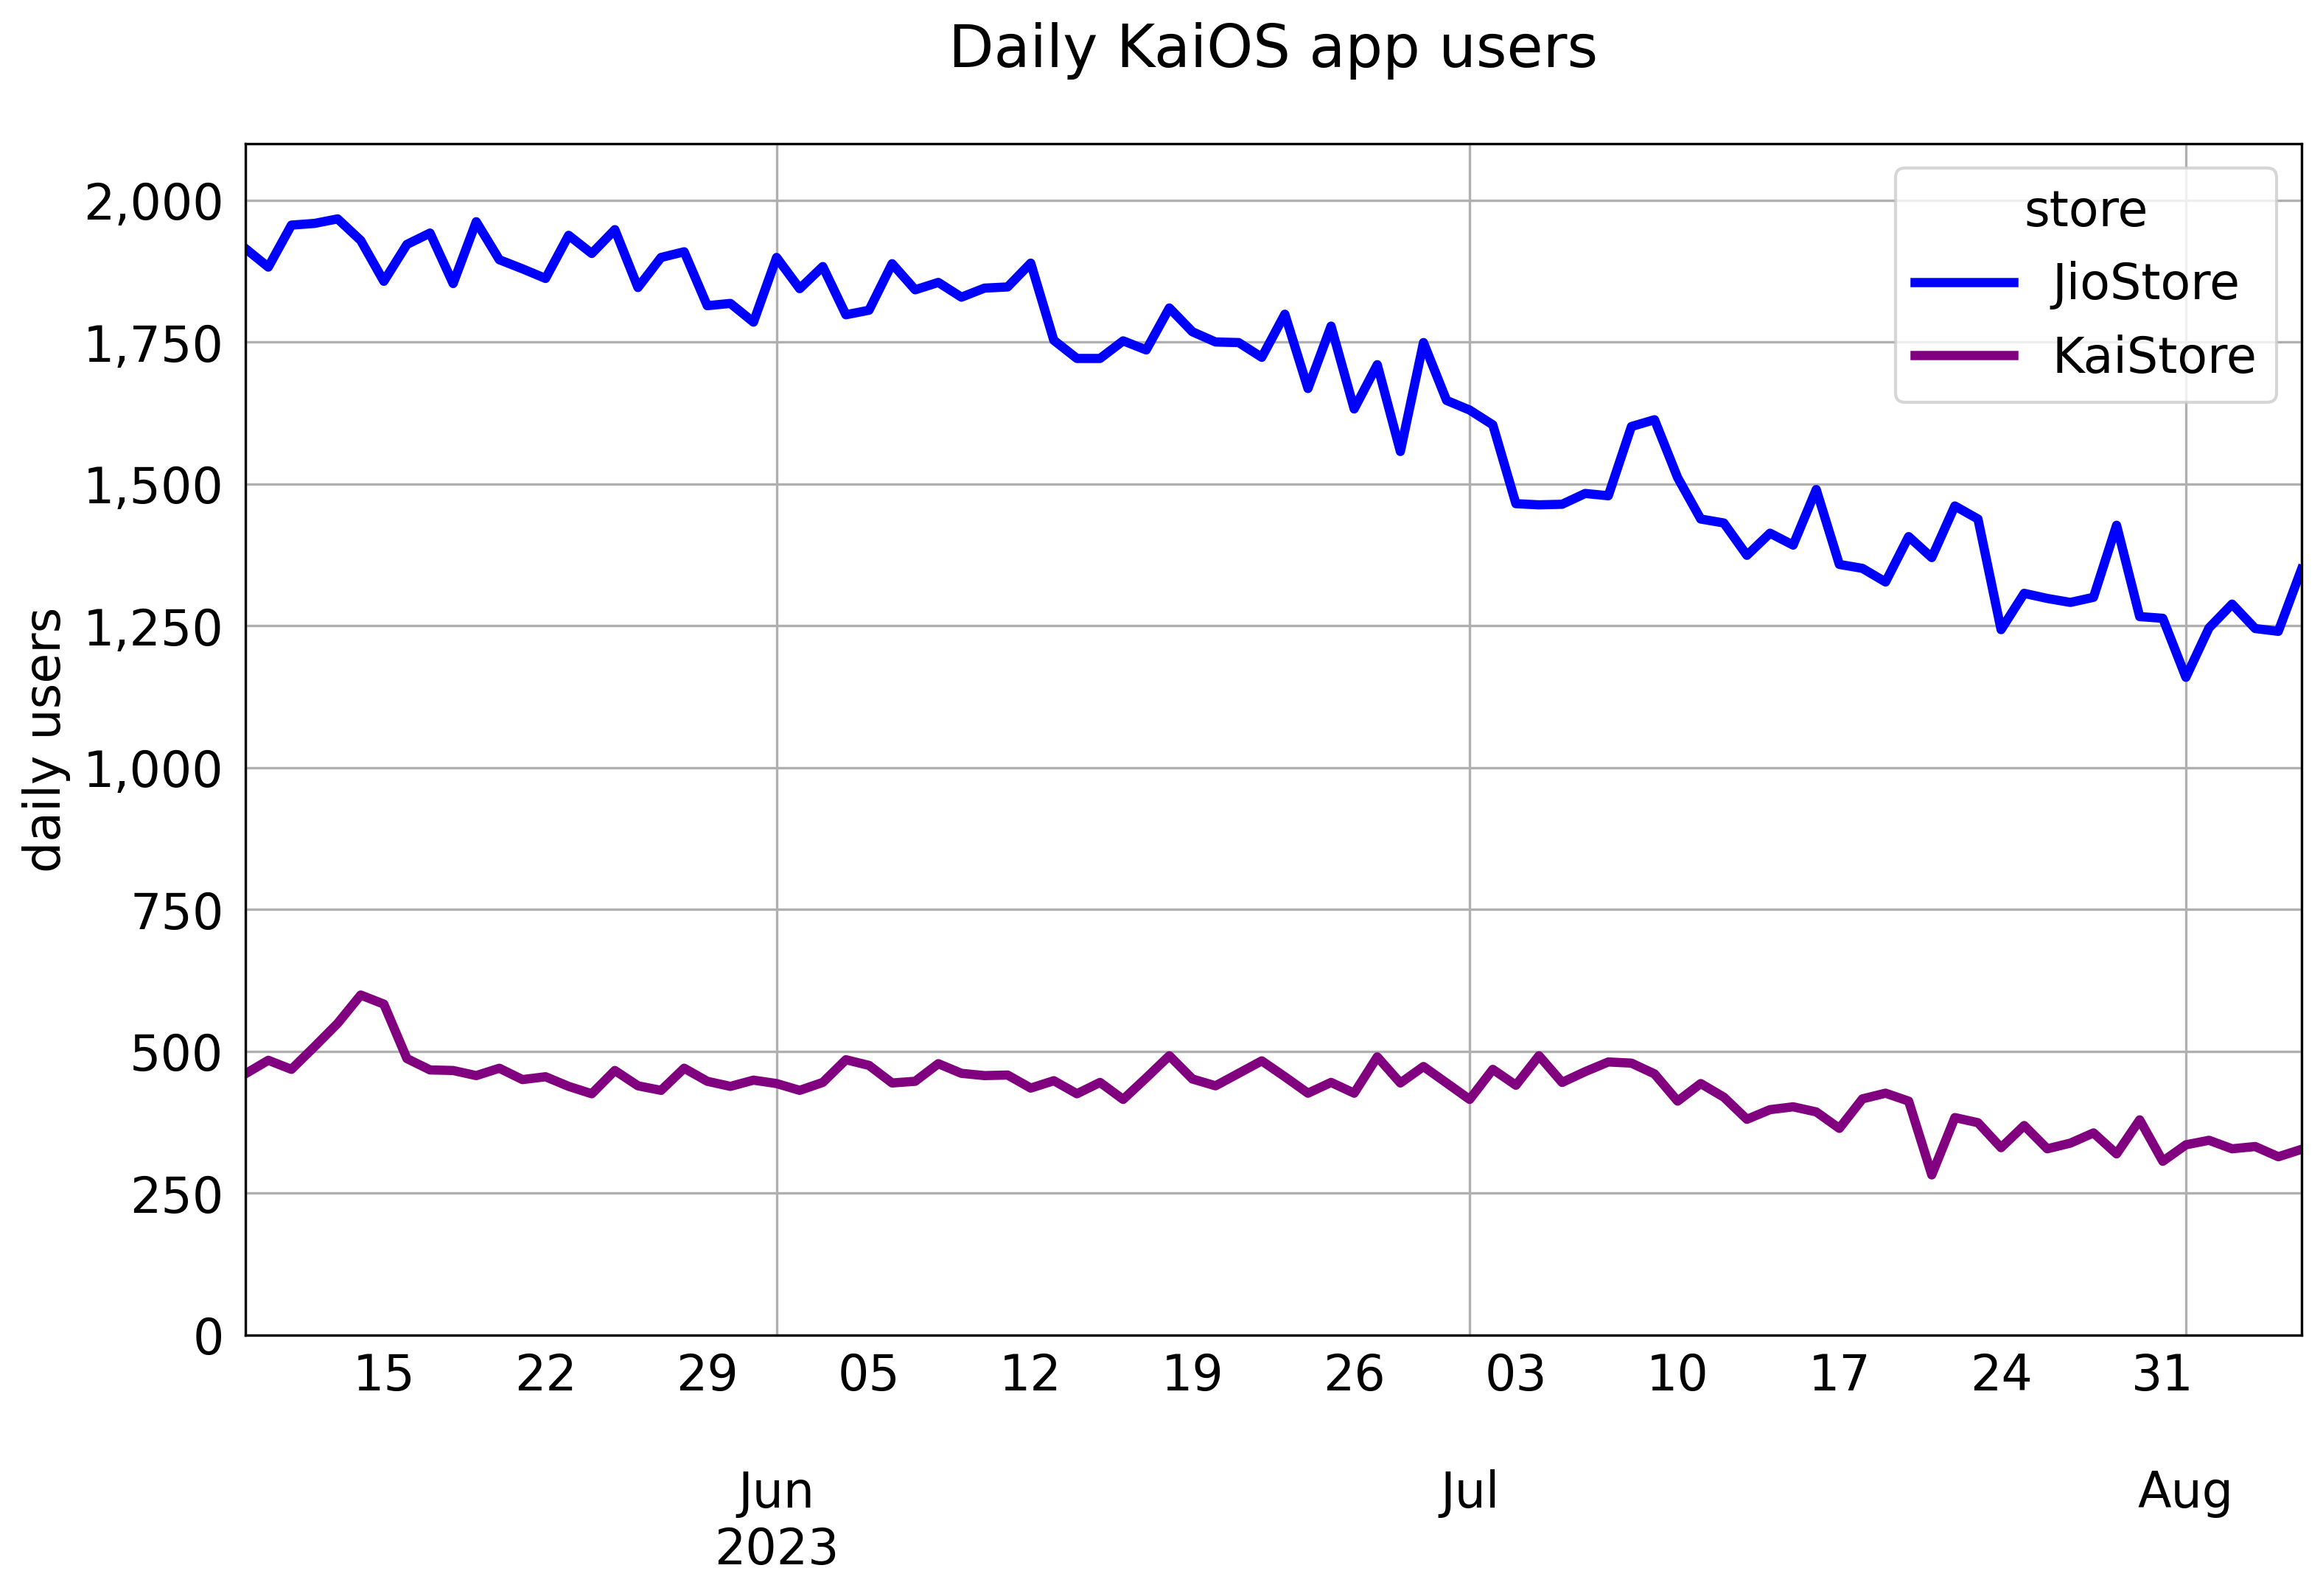

In [59]:
ax = (
    user
    .groupby(["dt", "store"])
    ["users"].sum()
    .unstack()
    .plot(color = ("blue", "purple"))
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 2100))

ax.set_title("Daily KaiOS app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users")


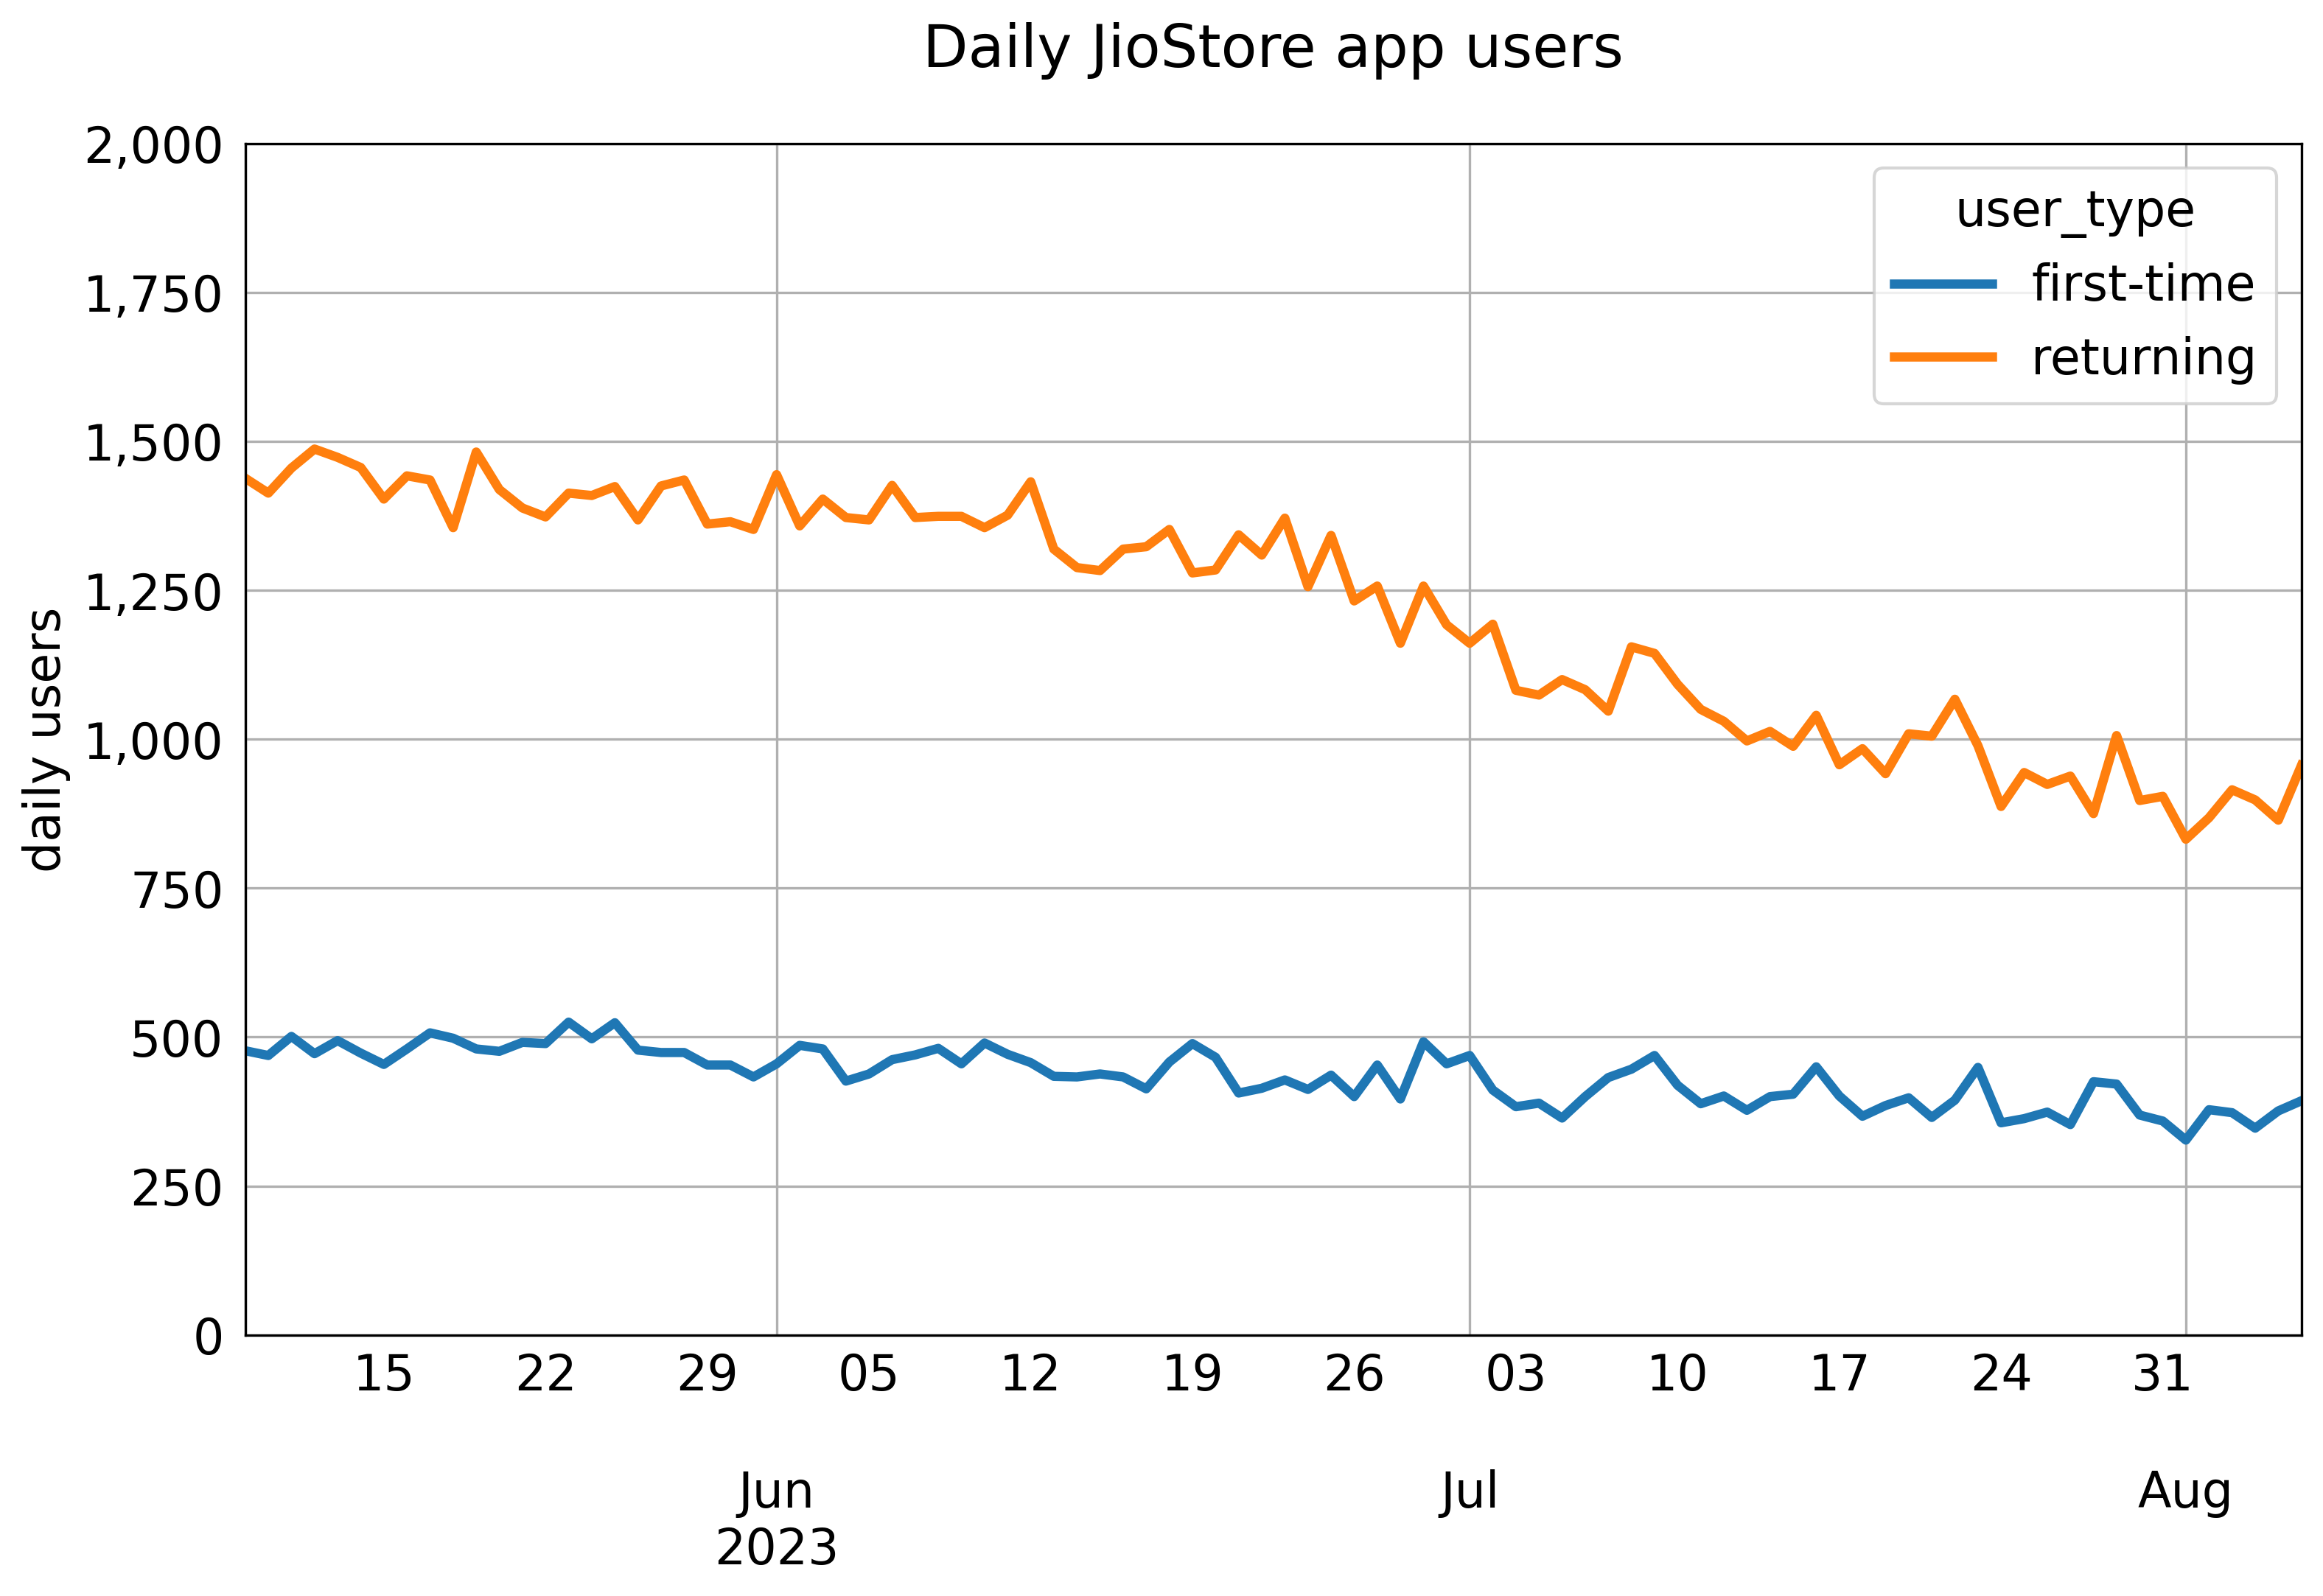

In [58]:
ax = (
    user
    .query("store == 'JioStore'")
    .drop(columns="store")
    .set_index("dt")
    .pivot(columns="user_type")
    .droplevel(0, axis="columns")
    .plot()
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 2000))

ax.set_title("Daily JioStore app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users");

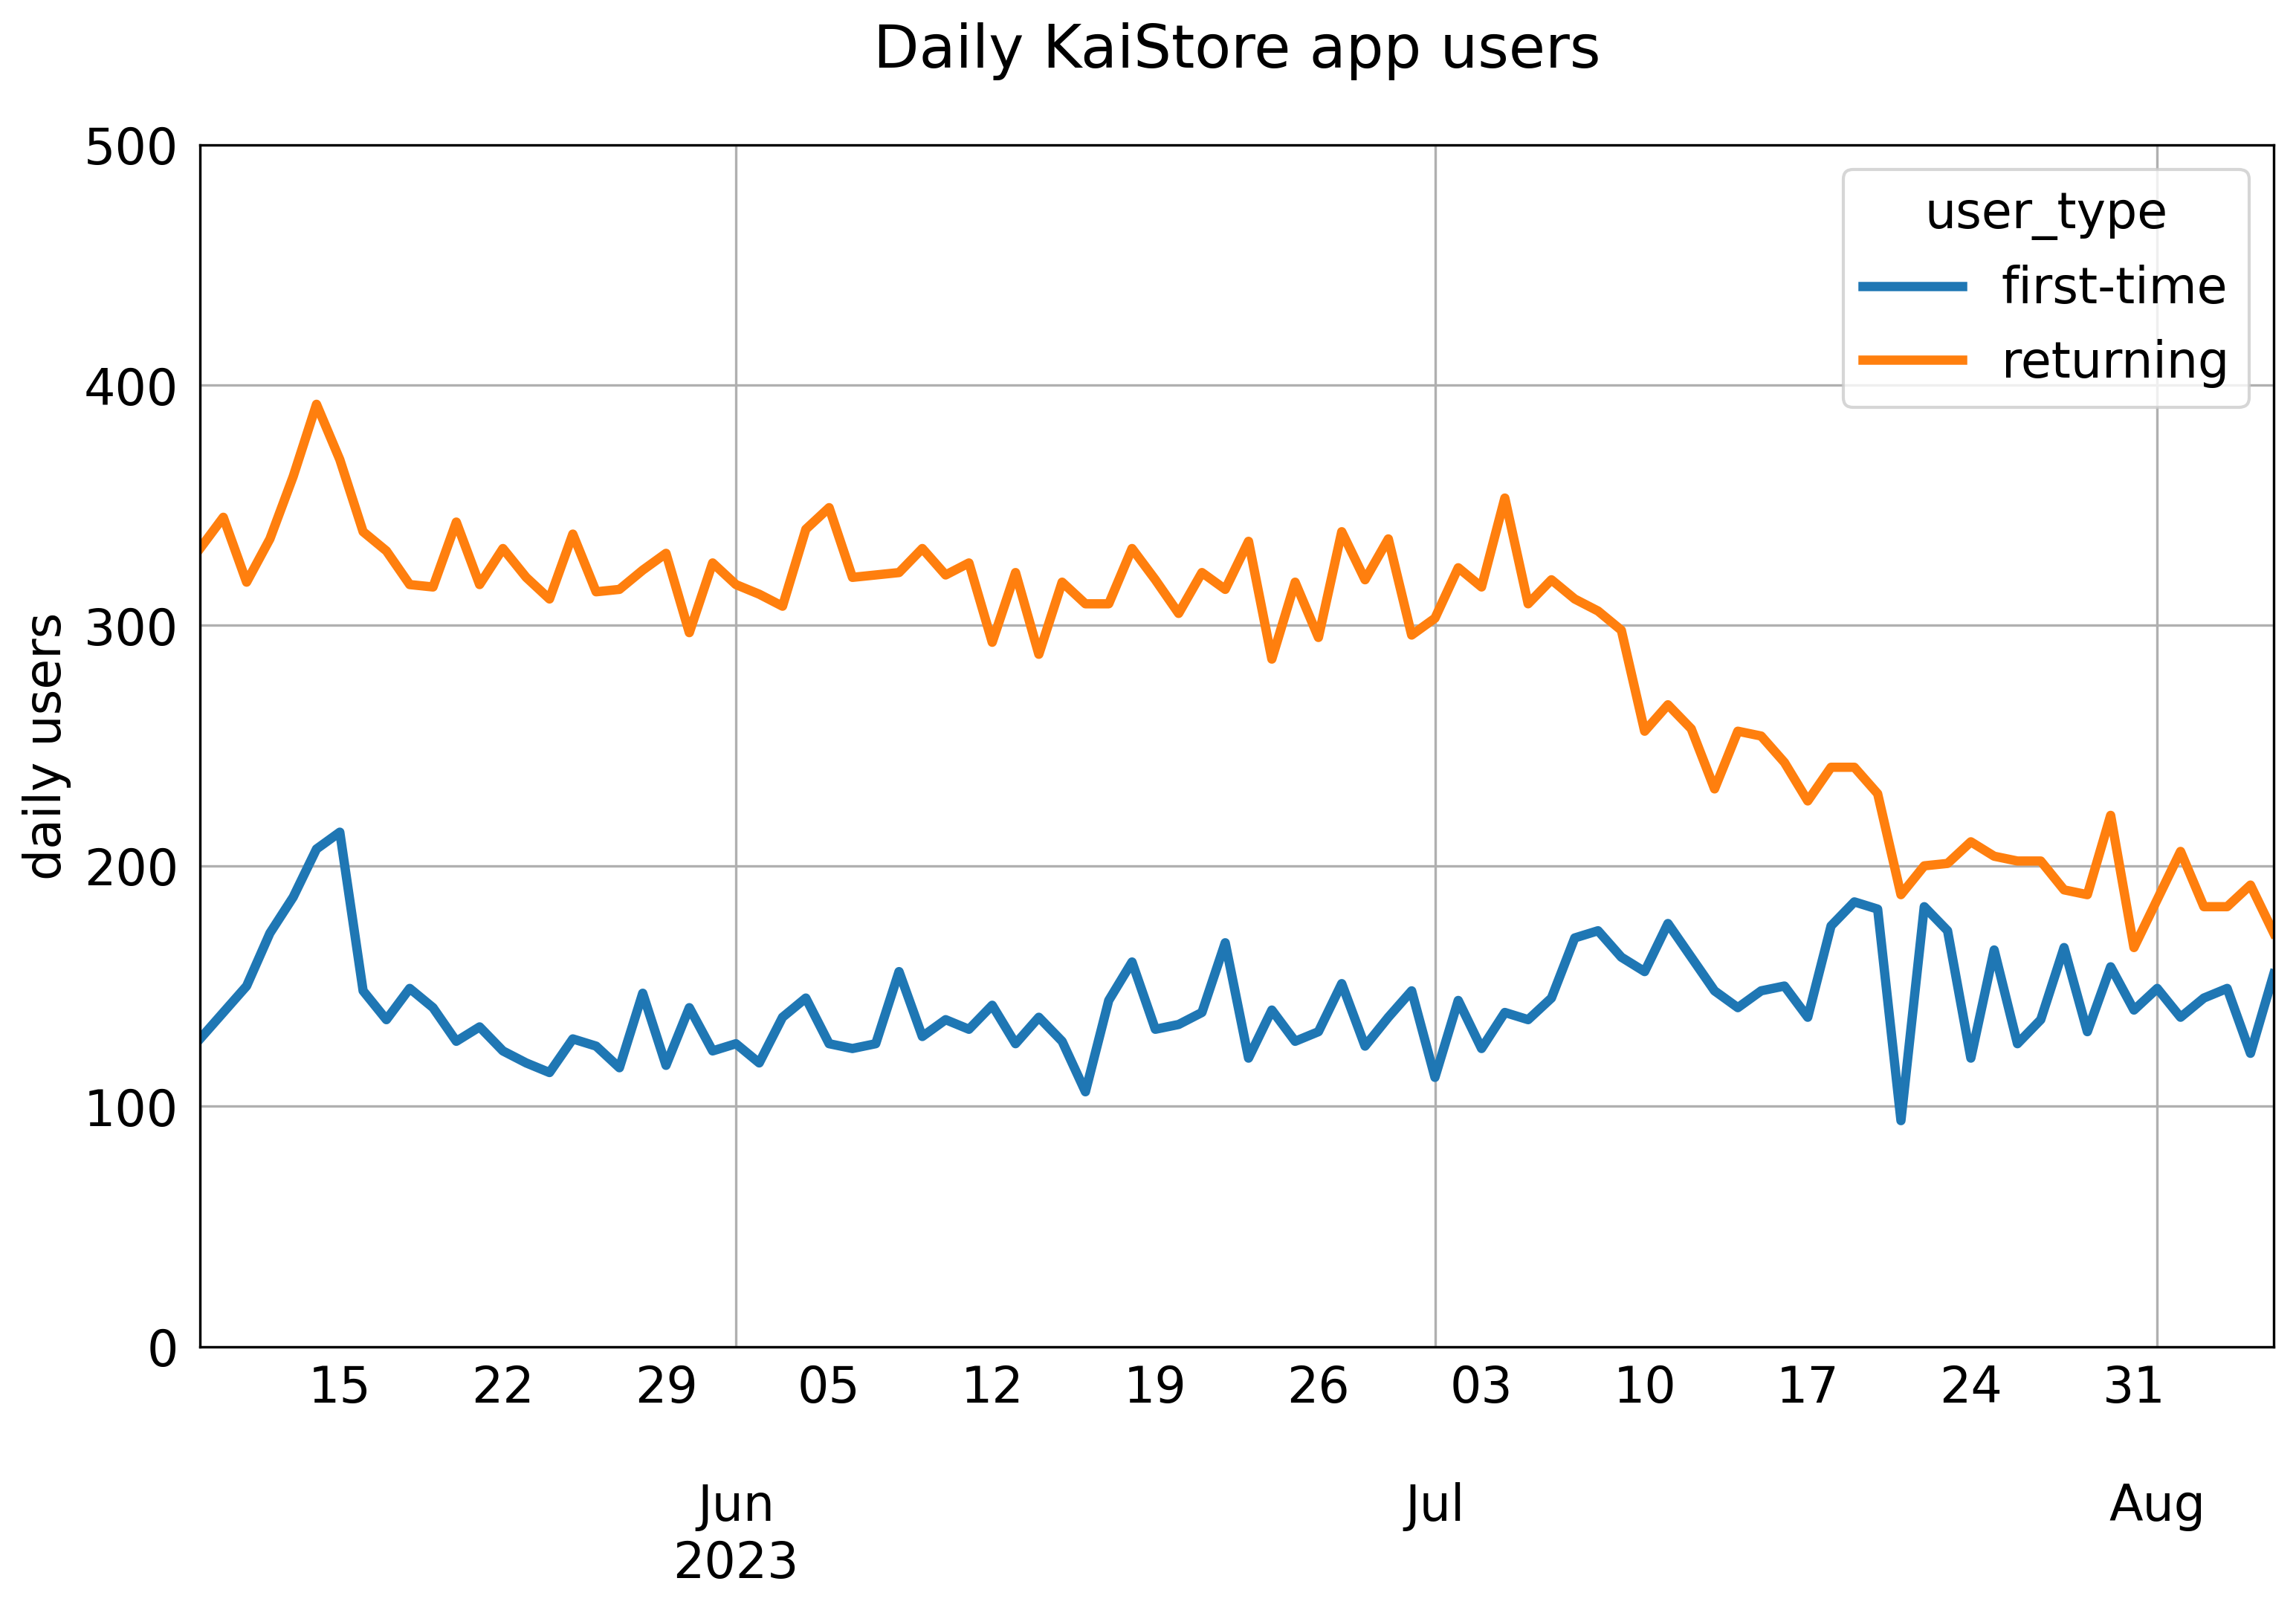

In [60]:
ax = (
    user
    .query("store == 'KaiStore'")
    .drop(columns="store")
    .set_index("dt")
    .pivot(columns="user_type")
    .droplevel(0, axis="columns")
    .plot()
)


ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylim((0, 500))

ax.set_title("Daily KaiStore app users", pad=25)
ax.set_xlabel("")
ax.set_ylabel("daily users");